In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import sys
import tensorflow as tf
import os
from threading import Thread
from datetime import datetime
import cv2
import shutil
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from PIL import Image
from PIL import ImageFile
from matplotlib import image
import seaborn as sns

In [ ]:
PARENT_PATH = os.getcwd()
DATA_PATH = os.path.join(os.getcwd(),"CombinedNew", "Combined New")
TEST_PATH = os.path.join(DATA_PATH, "test")
TRAIN_PATH = os.path.join(DATA_PATH, "train")
NEW_TRAIN_PATH = os.path.join(DATA_PATH, "new_train")
VALID_PATH = os.path.join(DATA_PATH, "valid")
UNSEEN_PATH = os.path.join(DATA_PATH, "unseen")
MODEL_PATH = "drive/MyDrive/models"
NUM_CLASSES = 8

In [ ]:
if os.path.exists(DATA_PATH):
  shutil.rmtree(DATA_PATH)
from zipfile import ZipFile
password = "57Rk!F8yUz38"
with ZipFile('drive/MyDrive/CombinedNew.zip') as zipObj:
  zipObj.extractall()

In [ ]:
for class_folder in os.listdir(TRAIN_PATH):
  class_path = os.path.join(TRAIN_PATH, class_folder)
  if class_folder == ".DS_Store":
      continue
  train_imgs, test_imgs = train_test_split(os.listdir(class_path), test_size=0.2, random_state = 42)

  for img in train_imgs: 
    src = os.path.join(class_path, img)
    dst = os.path.join(NEW_TRAIN_PATH, class_folder, img)
    if not os.path.exists(os.path.join(NEW_TRAIN_PATH, class_folder)):
      os.makedirs(os.path.join(NEW_TRAIN_PATH, class_folder))
    shutil.copy(src, dst)

  for img in test_imgs: 
    src = os.path.join(class_path, img)
    dst = os.path.join(VALID_PATH, class_folder, img)
    if not os.path.exists(os.path.join(VALID_PATH, class_folder)):
      os.makedirs(os.path.join(VALID_PATH, class_folder))
    shutil.copy(src, dst)

#### Extract hand

In [ ]:
MODEL_NAME = 'drive/MyDrive/models'
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(MODEL_NAME, 'hand_label_map.pbtxt')

NUM_CLASSES = 8

In [ ]:
# -----------------------------------------------
# Hand Detection
# -----------------------------------------------
# download model and proto buf from hhttps://github.com/molyswu/hand_detection/tree/temp/hand_detection/protos

def load_inference_graph():

    # load frozen tensorflow model into memory
    print("> ====== loading HAND frozen graph into memory")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        with tf.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def = tf.compat.v1.GraphDef()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
        sess = tf.compat.v1.Session(graph=detection_graph)
    print("> ======= Hand Inference graph loaded.")
    return detection_graph, sess


In [ ]:
def detect_objects(image_np, detection_graph, sess):
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    image_np_expanded = np.expand_dims(image_np, axis=0)

    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores,
            detection_classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
    return np.squeeze(boxes), np.squeeze(scores)

In [ ]:
detection_graph, sess = load_inference_graph()

> ====== loading HAND frozen graph into memory
> ======= Hand Inference graph loaded.


In [ ]:
def extractHand(ori_img, img_np, width, height): 
  hasHand = False
  boxes, scores = detect_objects(img_np, detection_graph, sess)
  # Create a blank white image with the same dimensions as the original image
  new_image = Image.new("RGB", (width, height), (255, 255, 255))

  for i, box in enumerate(boxes):
    # Get the box coordinates
    ymin, xmin, ymax, xmax = box
    ymin = int(ymin * img_np.shape[0])
    xmin = int(xmin * img_np.shape[1])
    ymax = int(ymax * img_np.shape[0])
    xmax = int(xmax * img_np.shape[1])
    if scores[i] > 0.4: 
      box_pixels = ori_img.crop((xmin, ymin, xmax, ymax))
      new_image.paste(box_pixels, (xmin, ymin))
      hasHand = True
  plt.imshow(new_image)
  plt.show()
  return new_image, hasHand
  

#### Extract face 

In [ ]:
modelFile = "drive/MyDrive/models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "drive/MyDrive/models/deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [ ]:
# -----------------------------------------------
# Face Detection using DNN Net
# -----------------------------------------------
# detect faces using a DNN model 
# download model and prototxt from https://github.com/spmallick/learnopencv/tree/master/FaceDetectionComparison/models

def detectFaceOpenCVDnn(net, frame):
    
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    blob = cv2.dnn.blobFromImage(frame, 1.0, mean = [104, 117, 123])

    net.setInput(blob)
    detections = net.forward()
    conf_threshold = 0.1
    box = None
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            conf_threshold = confidence
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            box = [x1, y1, x2, y2]

    if box == None:
        return []
    # extract the face
    face_boundary = frame[box[1]:box[3], box[0]:box[2]]

    # resize pixels to the model size
    # face_image = Image.fromarray(face_boundary)
    # face_array = np.asarray(face_image)

    return face_boundary

In [ ]:
def extractFace(image):
    hasFace = False
    frame = cv2.resize(image, (640, 480))

    extracted_face = detectFaceOpenCVDnn(net, frame)
    plt.imshow(extracted_face)
    plt.show()
    if (len(extracted_face) > 0):
        hasFace = True
    return extracted_face, hasFace

#### Predict image

In [3]:
ORI_MODEL_PATH = 'drive/MyDrive/models/distracted-inception_dropout_best.hdf5'
HAND_MODEL_PATH = 'drive/MyDrive/models/best_model_hand_molyswu.h5'
FACE_MODEL_PATH = 'drive/MyDrive/models/best_model_face_inception.h5'

In [8]:
ori_model = tf.keras.models.load_model(ORI_MODEL_PATH)
hand_model = tf.keras.models.load_model(HAND_MODEL_PATH)
face_model = tf.keras.models.load_model(FACE_MODEL_PATH)

In [ ]:
def predict(img_path):
  # extract hand
  img = Image.open(img_path)
  img_np = np.array(img)
  width, height = img.size
  hand_img, hasHand = extractHand(img, img_np, width, height)
  # extract face
  img_orig = cv2.imread(img_path)
  face_img, hasFace = extractFace(img_orig)
  # predict
  if (hasHand and hasFace):
      # for ensemble
      pass
  else: 
      img = img.resize((224, 224))
      img_array = np.array(img)
      img_array = np.expand_dims(img_array, axis=0)
      input_data = preprocess_input(img_array)
      y_pred = ori_model.predict(input_data)
      y_pred = np.argmax(y_pred, axis=1)
      print(y_pred)
  
  

#### Test

In [ ]:
img_path = os.path.join(TEST_PATH, 'c2', '1483875.jpg')

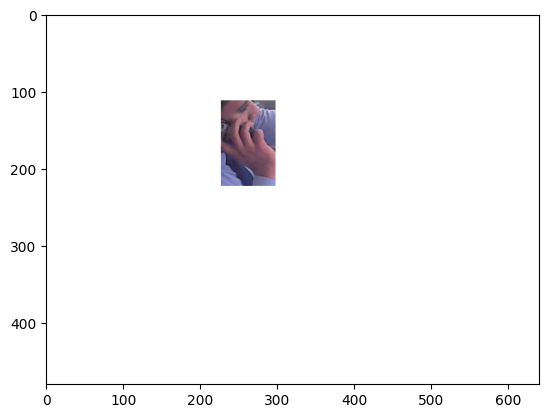

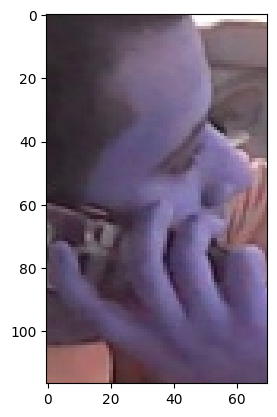

1/1 [==============================] - 2s 2s/step
[2]


In [ ]:
predict(img_path)